# Example 1-D: Hat tile
This example generates a basis of the local Poisson space $V_p(K)$ on a "hat tile" $K$.
The hat tile has been shown to nonperiodically tile the plane:
[D. Smith, J. S. Myers, C. S. Kaplan, and C. Goodman-Strauss. An aperiodic monotile, 2023.](https://arxiv.org/abs/2303.10798)

Each element $v$ of $V_p(K)$ has a polynomial Laplacian 
$\Delta v \in \mathbb{P}_{p-2}(K)$, and a piecewise polynomial trace 
$v|_{\partial K} \in \mathbb{P}_{p}^*(\partial K)$ such that the restriction 
to the boundary $v|_{\partial K}$ is continuous and the restriction to each edge
$v|_{e}$ is the trace of a polynomial of degree at most $p$ on $e$.
In the lowest order case, $V_1(K)$ consists of harmonic functions with a 
piecewise linear trace.

## Imports
As usual, we import the `puncturedfem` package. 
We will also need `numpy` and `matplotlib`.

In [1]:
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, ".."))
sys.path.append(parent_dir)

import puncturedfem as pf

import numpy as np
import matplotlib.pyplot as plt

## Construct the mesh cell


The hat tile can be constructed by joining the vertices of three regular
hexagons, along with the centers of the hexagons and midpoints of the faces.
We will generate all such points, including those we don't need, and then 
joining a subset of them to form the boundary of the hat tile.

In [2]:
r = np.sqrt(0.5 * (1 + np.cos(np.pi / 3.0)))

verts: list[pf.Vert] = []

for shift, i in zip([0, 1, 1], [0, 0, 1]):
    gamma = np.pi * (-2 * i + 1) / 6.0
    c_x = 2 * r * shift * np.cos(gamma)
    c_y = 2 * r * shift * np.sin(gamma)

    verts.append(pf.Vert(c_x, c_y))

    for j in range(6):
        alpha = np.pi * j / 3.0
        a_x = np.cos(alpha)
        a_y = np.sin(alpha)

        beta = np.pi * (2 * j + 1) / 6.0
        b_x = r * np.cos(beta)
        b_y = r * np.sin(beta)

        verts.append(pf.Vert(a_x + c_x, a_y + c_y))
        verts.append(pf.Vert(b_x + c_x, b_y + c_y))

We have generated some redudant points, so let's remove them.

In [3]:
unique_verts: list[pf.Vert] = []
for v in verts:
    v_is_in_unique_verts = False
    for w in unique_verts:
        if v == w:
            v_is_in_unique_verts = True
            break
    if not v_is_in_unique_verts:
        unique_verts.append(v)
verts = unique_verts
for i, v in enumerate(verts):
    v.set_idx(i)

Let's plot the points to make sure we have what we want. We will also include 
the indices of the points, so we know which ones to connect with edges.

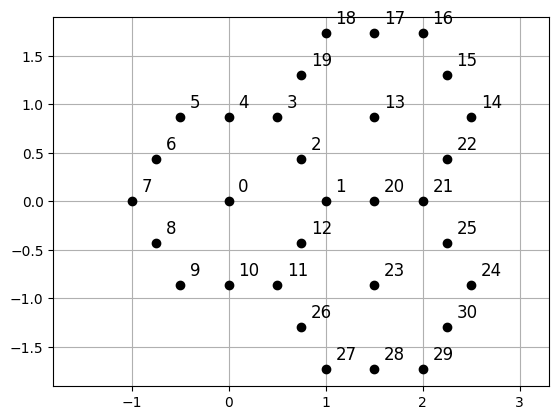

In [4]:
plt.figure()
for v in verts:
    plt.plot(v.x, v.y, "ko")
    plt.text(v.x + 0.1, v.y + 0.1, f"{v.idx}", fontsize=12)
plt.axis("equal")
plt.grid("on")
plt.show()

Next, we make a list of the vertices that we want to connect with edges.

In [5]:
path_idx: list[int] = [0, 8, 9, 11, 12, 23, 25, 21, 20, 13, 19, 3, 4, 0]

We are finally prepared to join the vertices with edges. 

In [6]:
path: list[pf.Vert] = []
for idx in path_idx:
    v = [v for v in verts if v.idx == idx][0]
    path.append(v)
edges = [
    pf.Edge(anchor=path[i], endpnt=path[i + 1], pos_cell_idx=0, idx=i)
    for i in range(len(path) - 1)
]

With the edges defined, let's make the mesh cell $K$.

In [7]:
K = pf.MeshCell(idx=0, edges=edges)

Let's parameterize the edges, and plot the edges to check that we have what we 
want.

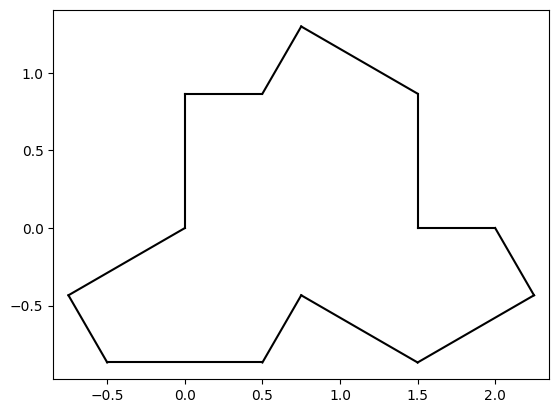

In [8]:
quad_dict = pf.get_quad_dict(n=16)
K.parameterize(quad_dict)
pf.plot.MeshPlot(K.get_edges()).draw()

## Build local Poisson space
With the mesh cell $K$ defined, we are prepared to construct the local Poisson
space $V_p(K)$.
The polynomial degree $p$ is specified by the user by passing the `deg`
keyword argument to the `LocalPoissonSpace` constructor.

Depending on the degree and the edge discretization parameter `n` we chose 
above, this may take a couple of minutes.

In [9]:
V = pf.LocalFunctionSpace(K, deg=3)

Setting up Nyström Solver... 416 sampled points on 13 Edges
Computing function metadata...


100%|██████████| 42/42 [00:00<00:00, 85.12it/s]


Finding interior values...


100%|██████████| 42/42 [00:49<00:00,  1.17s/it]


It holds that the dimension of the local Poisson space is given by 
$$
    \dim V_p(K) = {p \choose 2}
    -|E(\partial K)|
    + \sum_{e \in E(\partial K)} \dim \mathbb{P}_p(e)
$$
where $E(\partial K)$ is the set of edges of the boundary of $K$,
and $\dim \mathbb{P}_p(e)$ is the dimension of the *edge space* on $e$,
consisting of traces of polynomials of degree at most $p$ on $e$.
The dimension of this edge space depends on the nature of the edge $e$.
In our case, each edge of the boundary is a line segment, so
$$
    \dim \mathbb{P}_p(e) = p + 1
$$
so we have
$$
    \dim V_p(K) = {p \choose 2} + p \, \underbrace{|E(\partial K)|}_{=13}.
$$
Here is a table of the dimensions of the local Poisson spaces for the first
few values of $p$.

| $p$ | $\dim V_p(K)$ |
| --- | --- |
| 1 | 13 |
| 2 | 27 |
| 3 | 42 |

Let's verify that the dimension of the local Poisson space is what we expect.

In [10]:
print(f"polynomial degree: p = {V.deg}")
print(f"number of edges: {K.num_edges}")
print(f"dim(V_{V.deg}(K)) = {V.num_funs}")

polynomial degree: p = 3
number of edges: 13
dim(V_3(K)) = 42


## Plot the basis functions
Let's plot the basis functions to see what they look like.

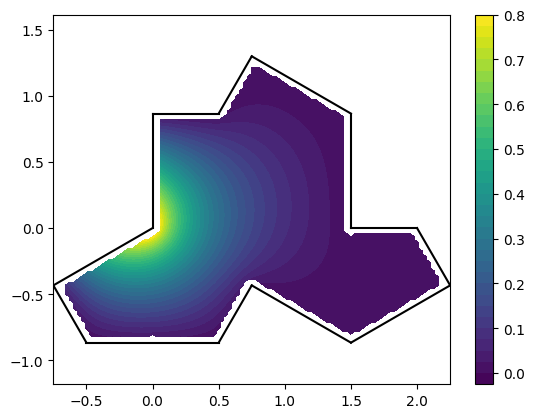

FileNotFoundError: [Errno 2] No such file or directory: 'out/monotile_deg3_Vert_0.pdf'

<Figure size 640x480 with 0 Axes>

In [11]:
for i, v in enumerate(V.get_basis()):
    pf.plot.LocalFunctionPlot(v).draw_vals(
        filename=f"out/monotile_deg{V.deg}_{v.key.fun_type}_{i}.pdf",
        show_plot=True,
    )